# **30 Day Forecast: Amberpet Mandal Weather Conditions**

# **Notebook 2: Exploratory Data Analysis**

In [2]:
# Libraries required for exploratory data analysis
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import math  # For mathematical operations

from statsmodels.tsa.seasonal import seasonal_decompose # For seasonal decomposition of time series
from scipy.stats import skew # For calculating skewness

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 1.6 Exploratory Data Analysis

In [10]:
# load 'Amberpet_weather_cleaned.csv'
Amberpet_weather_cleaned = pd.read_csv('Amberpet_weather_cleaned.csv', parse_dates=['Date'], index_col='Date')
Amberpet_weather_cleaned.head()

,Rain (mm),Min Temp (°C),Max Temp (°C),Min Humidity (%),Max Humidity (%),Min Wind Speed (Kmph),Max Wind Speed (Kmph)
Date,,,,,,,
2023-02-01,0.0,21.5,29.7,42.2,78.6,0.0,2.0
2023-02-02,0.0,19.9,30.4,37.0,73.6,0.0,1.9
2023-02-03,0.0,18.5,30.1,27.8,55.1,0.0,2.0
2023-02-04,0.0,19.1,31.4,15.6,60.3,0.0,2.1
2023-02-05,0.0,20.1,31.9,24.2,58.1,0.0,2.1


In [11]:
# Confirm data types and check for any remaining missing values
Amberpet_weather_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2023-02-01 to 2025-01-31
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Rain (mm)              731 non-null    float64
 1   Min Temp (°C)          731 non-null    float64
 2   Max Temp (°C)          731 non-null    float64
 3   Min Humidity (%)       731 non-null    float64
 4   Max Humidity (%)       731 non-null    float64
 5   Min Wind Speed (Kmph)  731 non-null    float64
 6   Max Wind Speed (Kmph)  731 non-null    float64
dtypes: float64(7)
memory usage: 45.7 KB


Data has 731 rows and 7 columns.

The data has no missing values.

### 1.6.1 Summary Statistics

In [12]:
# summarize the dataset
Amberpet_weather_cleaned.describe()

,Rain (mm),Min Temp (°C),Max Temp (°C),Min Humidity (%),Max Humidity (%),Min Wind Speed (Kmph),Max Wind Speed (Kmph)
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.574008,23.145691,34.031053,39.627633,81.934884,0.532558,11.734337
std,9.024621,3.045471,3.461840,15.478923,13.705055,1.464542,10.417097
min,0.000000,13.800000,23.900000,10.300000,32.300000,0.000000,0.000000
25%,0.000000,21.300000,32.250000,27.750000,73.150000,0.000000,6.900000
50%,0.000000,23.400000,33.600000,38.500000,85.100000,0.000000,10.000000
75%,0.000000,25.100000,36.000000,49.000000,92.900000,0.100000,13.400000
max,74.700000,31.100000,43.000000,91.200000,100.000000,15.500000,69.500000


3 variables; Rain (mm), Min Wind Speed( Kmph) and Max Wind Speed(Kmph) have '0' values.

### 1.6.2 Distribution of weather variables

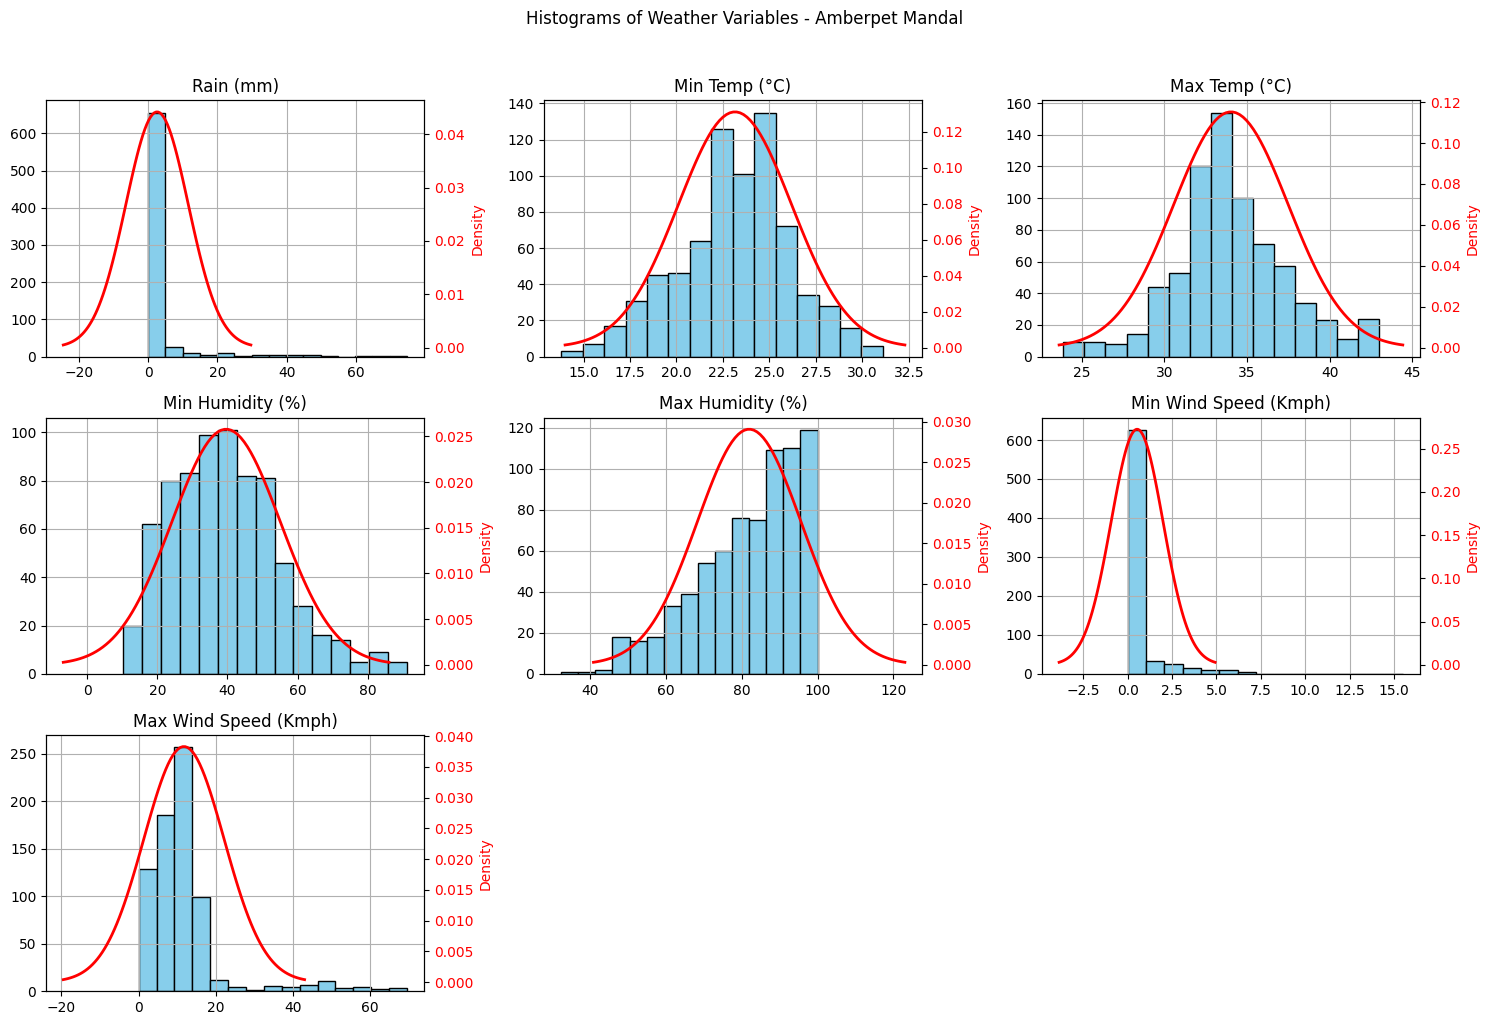

In [13]:
# plot histograms for each variable to see their distributions
Amberpet_weather_cleaned.hist(bins=15, figsize=(15, 10), layout=(3, 3), color='skyblue', edgecolor='black')
# include a normal distribution curve on each histogram
for ax, column in zip(plt.gcf().axes, Amberpet_weather_cleaned.columns):
    mu = Amberpet_weather_cleaned[column].mean()
    sigma = Amberpet_weather_cleaned[column].std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    p = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    ax2 = ax.twinx()
    ax2.plot(x, p, 'r-', linewidth=2)
    ax2.set_ylabel('Density', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
plt.suptitle('Histograms of Weather Variables - Amberpet Mandal', y=1.02) # Adjust y for title position
plt.tight_layout()
plt.show()

**Distribution Analysis & Modeling Implications**

**1. Rain (mm) - Extreme Right Skew**
- Massive spike at 0 (most days are dry)
- Long right tail with rare heavy rainfall events
- NOT normally distributed despite the overlay curve
- **Recommendations:**
  - Option A: Two-stage model (classify rain/no-rain, then predict amount)
  - Option B: Log transformation: log1p(rain)
  - Option C: Use models that handle zero-inflation (e.g., Zero-Inflated Poisson regression layer)

**2. Temperatures - Approximately Normal distribution**
- Min Temp: Slight left skew, but reasonable
- Max Temp: Nearly perfect normal distribution
- **Recommendations: Standard scaling. No transformation needed**

**3.Humidity Variables - Different Behaviors**
- Min Humidity: Roughly normal distribution with slight right skew
- Max Humidity: Left-skewed (clustered near 100%). Many days hit 100% max humidity (morning dew/fog)
- **Recomendation: Consider capping or creating binary is_saturated feature**

**4.Min Wind Speed - Zero-Inflated models recommended**
- Extreme concentration at 0 km/h. Essentially useless for prediction
- **Recommendation: DROP variable.** 

**5.Max Wind Speed - Right Skewed**
- Most days have low wind (5-15 km/h). Rare extreme wind events (outliers up to 70 km/h)
- **Recommendation - Consider log transformation or robust scaling**

The variables will be transformed before being used for model building

### 1.6.3 Outlier detection and spread

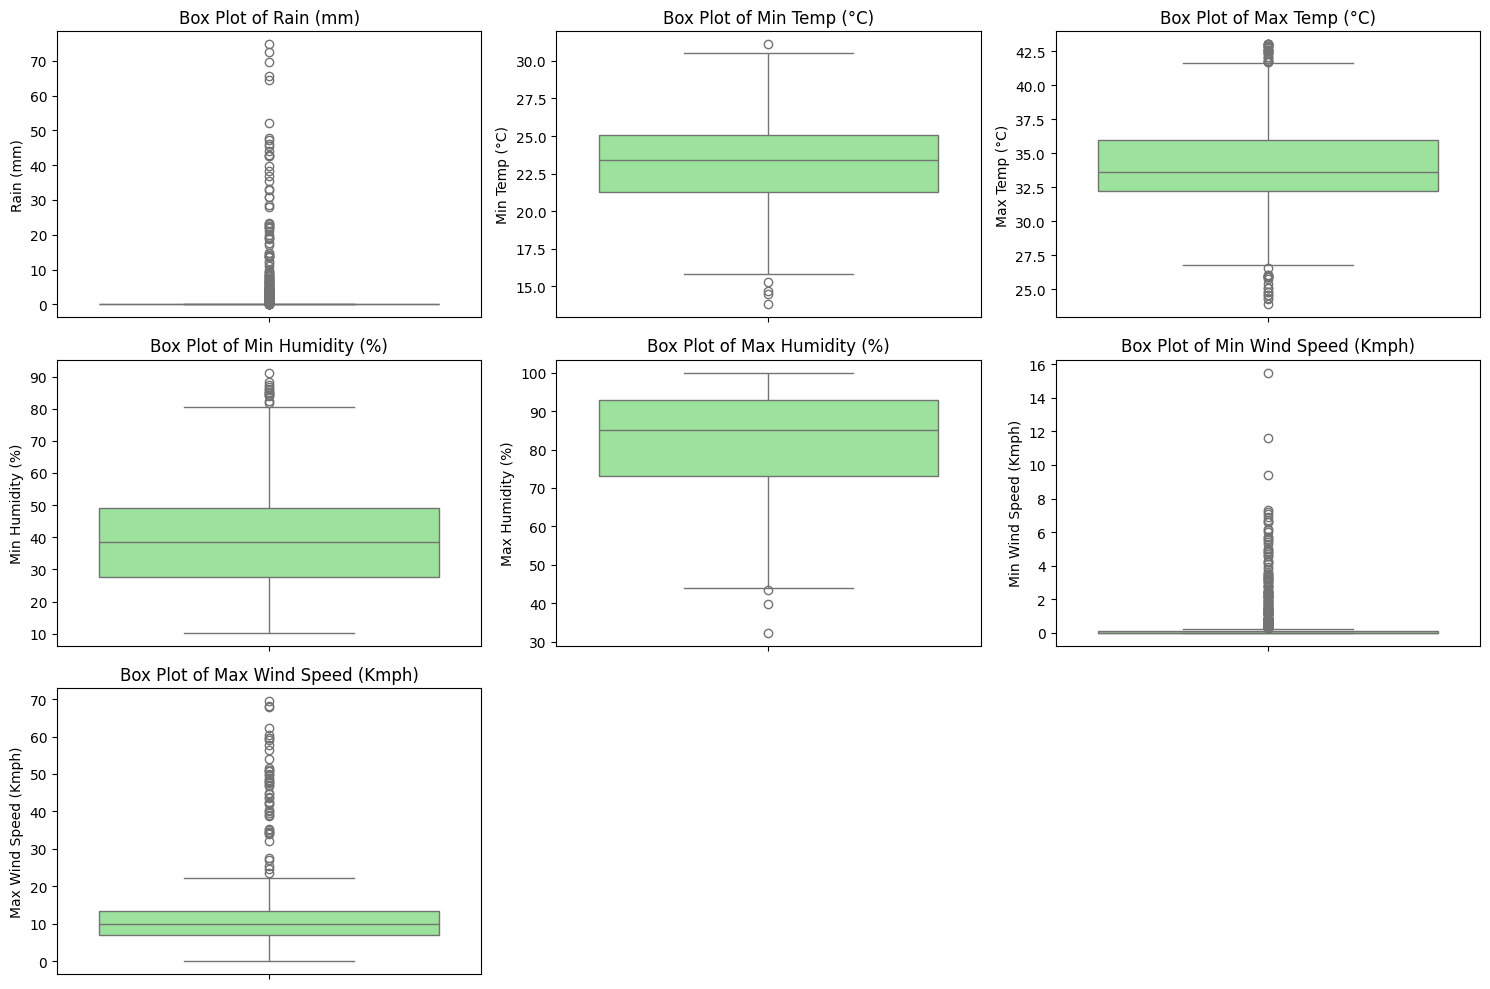

In [14]:
# plot box plots to visualize the spread and identify outliers
plt.figure(figsize=(15, 10))
for i, column in enumerate(Amberpet_weather_cleaned.columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=Amberpet_weather_cleaned[column], color='lightgreen')
    plt.title(f'Box Plot of {column}')
plt.tight_layout()
plt.show()

Interpretation
- Rain (mm) - right-skewed, many outliers—typical of sporadic heavy rainfall.
- Min Temp (°C)	Narrow IQR (21 - 25 degrees), a few outliers either low temps or high temps, suggesting stable nighttime temperatures.
- Max Temp (°C)	Wider spread (31 - 36 degrees), possibly seasonal variation or daytime extremes, many outlier temps either low or high temps
- Min Humidity (%) - many outliers in the higher % range, wide spread
- Max Humidity (%) - Possibly left-skewed—high humidity is common, but extreme lows are rare, some outliers. wide spread
- Min Wind Speed (Kmph) - tight distribution, possibly near-zero values, many outliers. 
- Max Wind Speed (Kmph) - Wider range, many outliers during storms or gusts.(higher speeds). Overall lower peak wind speeds. 

Variables with many outliers: Rain (mm), Max Temp (°C), Min Humidity (%), Min Wind Speed (Kmph) & Max Wind Speed (Kmph). This will need to be handled. 

Variables with few outliers: max humidity & min temp.

### 1.6.4 Seasonal Variations and outliers

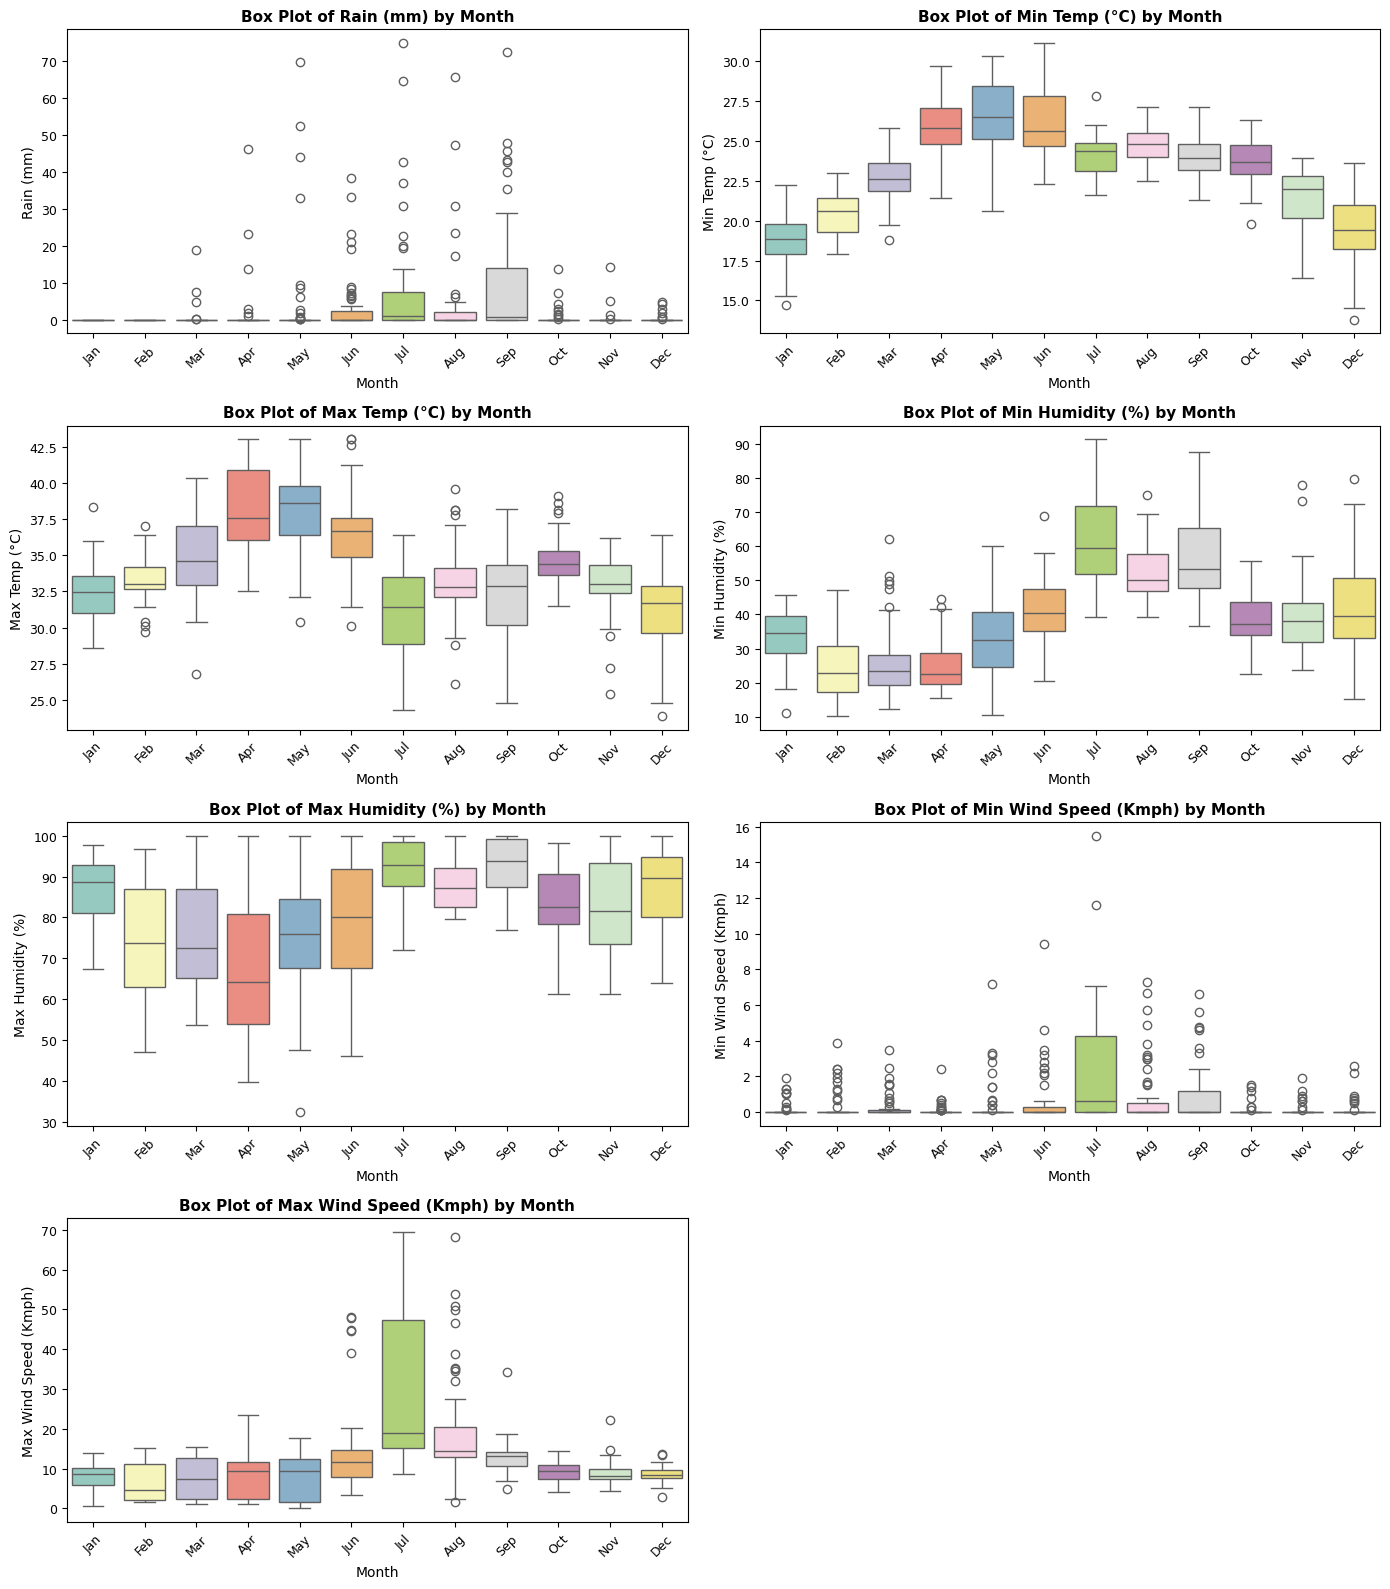

In [15]:
# Plot box plots by month to see seasonal variations and outliers
fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.flatten()

for i, column in enumerate(Amberpet_weather_cleaned.columns):
    sns.boxplot(x=Amberpet_weather_cleaned.index.month, y=Amberpet_weather_cleaned[column], 
                palette='Set3', ax=axes[i]) # Set3 is a qualitative color palette
    axes[i].set_title(f'Box Plot of {column} by Month', fontsize=11, fontweight='bold') # Title with bold font
    axes[i].set_xlabel('Month', fontsize=10) # X-axis label
    axes[i].set_ylabel(column, fontsize=10) # Y-axis label
    axes[i].tick_params(labelsize=9) # Tick label size
    axes[i].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45) # Month names with rotation

# Hide the last empty subplot (since there are 7 variables and 8 subplots)
axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

**Weather Pattern Insights**

**1. Rain (mm) - Highly Seasonal & Sparse**
- Monsoon months (Jun-Sep): Heavy rainfall with many outliers. Dry months (Oct-May): Mostly 0 mm (boxes are flat)
- **Action: Create binary feature is_monsoon and consider zero-inflated models or separate rain/no-rain classification**

**2. Temperature - Clear Seasonal Cycles**
- Hottest: April-May (pre-monsoon summer). Coolest: December-January (winter). Min Temp range: 14-30°C, Max Temp: 24-43°C
- **Strong seasonal pattern = good for time-based features**

**3. Humidity - Monsoon Effect**
- Max Humidity: Consistently high (80-100%) across months. 
- Min Humidity: Drops significantly in dry months. Jan-May: 20-40%. Jul-Aug: High min humidity due to monsoon.
- **Clear inverse relationship with temperature**

**4. Wind Speed Issues**
- **Min Wind Speed:**
  - Nearly all months show 0 km/h median with extreme outliers, all months.
  - **Recommendation: Drop feature - it has almost no variance and will not help predictions**
- **Max Wind Speed:**
  - July spike is dramatic (15-47 km/h median, up to 70 km/h). 
  - Monsoon wind storms clearly visible. 
  - **Many outliers - alot in August. Other months - June, September, November, December**

### 1.6.5 Comprehensive diagnostics function for checking skewness, zero-inflation, outliers, and transformation recommendations

In [16]:
# Comprehensive diagnostics function for checking skewness, zero-inflation, outliers, and transformation recommendations
# zero-inflation ratio thresholds: >30% high, 10-30% moderate, <10% low
# zero inflation tells what proportion of the data points are exactly zero.
def generate_diagnostics(df, variables):
    report = []

    for var in variables:
        data = df[var]
        skew_val = skew(data.dropna())
        zero_ratio = (data == 0).mean()
        Q1, Q3 = data.quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        outlier_count = ((data < lower) | (data > upper)).sum()

        # Transformation recommendation
        if skew_val > 1:
            transform = "Log or Box-Cox"
        elif skew_val < -1:
            transform = "Square or Exponential"
        else:
            transform = "None"

        # Zero-inflation flag
        if zero_ratio > 0.3:
            zero_flag = "High (Consider zero-inflated models)"
        elif zero_ratio > 0.1:
            zero_flag = "Moderate"
        else:
            zero_flag = "Low"

        report.append({
            "Variable": var,
            "Skewness": round(skew_val, 3),
            "Zero Ratio": round(zero_ratio, 3),
            "Outlier Count": int(outlier_count),
            "Suggested Transformation": transform,
            "Zero Inflation": zero_flag
        })

    return pd.DataFrame(report)
diagnostic_report = generate_diagnostics(Amberpet_weather_cleaned, Amberpet_weather_cleaned.columns)
print(diagnostic_report)


                Variable  Skewness  Zero Ratio  Outlier Count  \
0              Rain (mm)     4.929       0.770            168   
1          Min Temp (°C)    -0.239       0.000              5   
2          Max Temp (°C)     0.176       0.000             45   
3       Min Humidity (%)     0.628       0.000             14   
4       Max Humidity (%)    -0.761       0.000              3   
5  Min Wind Speed (Kmph)     4.291       0.739            161   
6  Max Wind Speed (Kmph)     2.869       0.016             48   

  Suggested Transformation                        Zero Inflation  
0           Log or Box-Cox  High (Consider zero-inflated models)  
1                     None                                   Low  
2                     None                                   Low  
3                     None                                   Low  
4                     None                                   Low  
5           Log or Box-Cox  High (Consider zero-inflated models)  
6         

### 1.6.6 Correlation analysis between variables

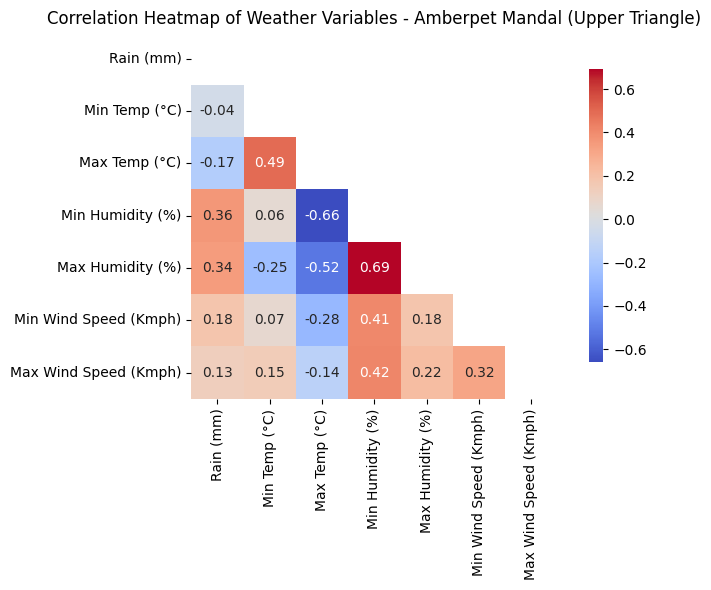

In [17]:
# plot a correlation heatmap to visualize relationships between variables
correlation_matrix = Amberpet_weather_cleaned.corr()

# show one half of the matrix to avoid redundancy
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Weather Variables - Amberpet Mandal (Upper Triangle)')
plt.tight_layout()
plt.show()

Interpretation:

**Strong correlations**
- **Max Humidity vs. Min Humidity (0.69)** - strong positive correlation. Days with high peak humidity also tend to have higher minimum humidity. Suggests consistent moisture levels across the day—possibly during monsoon or humid seasons.
- **Max Temp vs. Min Humidity (-0.66)** - strong negative correlation. As daytime temperatures rise, the minimum humidity tends to drop. This reflects typical diurnal drying—hotter air holds more moisture, lowering relative humidity unless moisture increases
- **Max Humidity vs. Max Temperature (-0.52)** - moderate negative correlation: As peak humidity increases, peak temperatures reduce. 
  
**Weak correlations**
- Min Temp vs. Rain (-0.04) - weak negative correlation
- Min Humidity vs. min Temp (0.06) - weak positive correlation

### 1.6.7 Data Visualization using Line plots

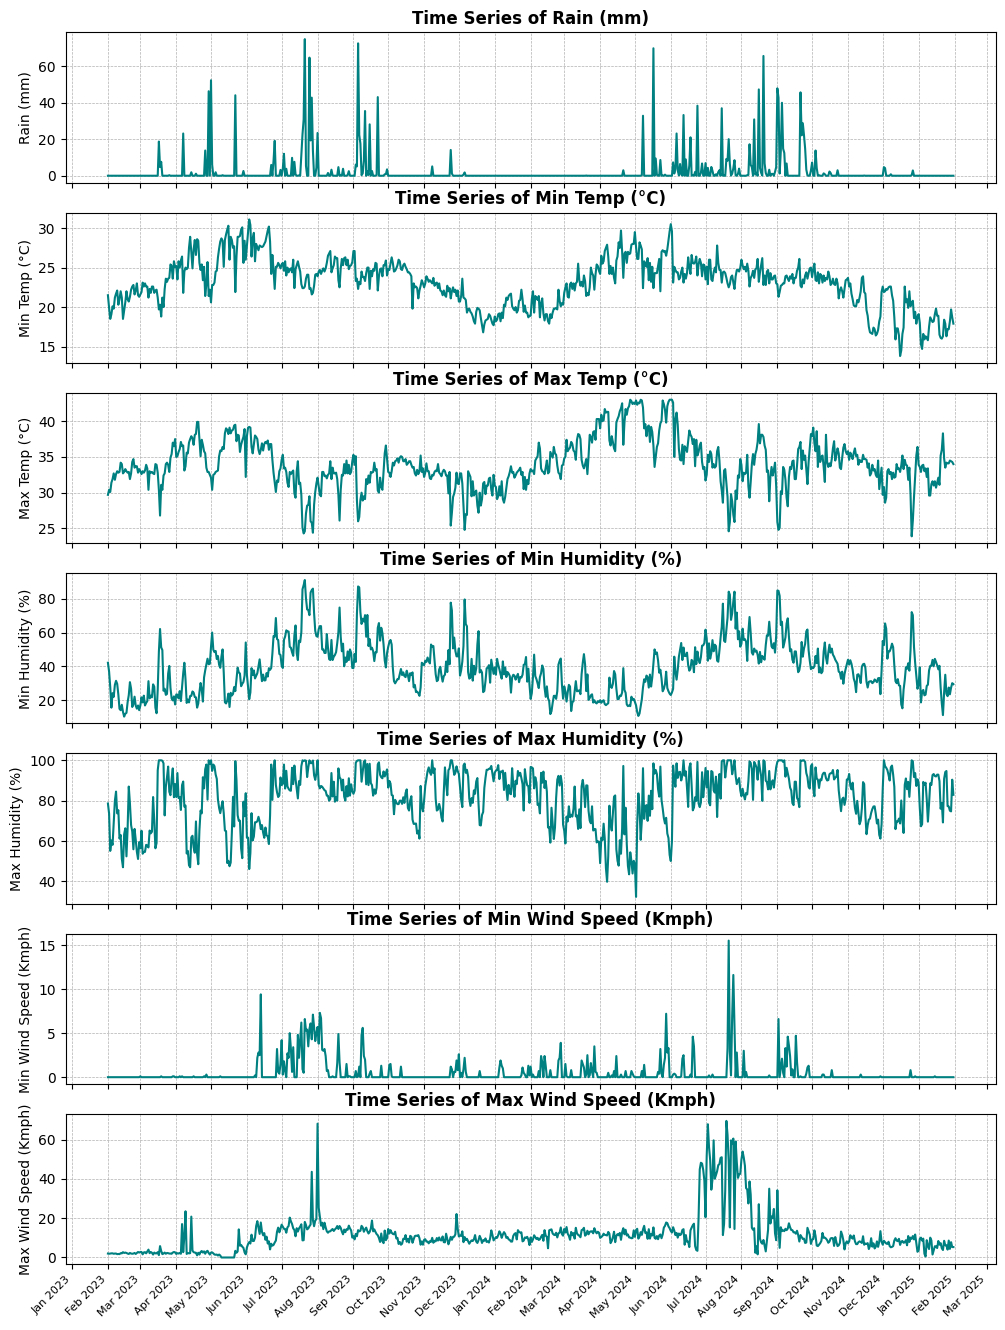

In [18]:
# lineplots for each variable to observe trends and seasonality
# include gridlines for better readability
# include month and yearly major ticks
fig, axes = plt.subplots(len(Amberpet_weather_cleaned.columns), 1, figsize=(12, 16), sharex=True)
for i, column in enumerate(Amberpet_weather_cleaned.columns):
    axes[i].plot(Amberpet_weather_cleaned.index, Amberpet_weather_cleaned[column], color='teal')
    axes[i].set_title(f'Time Series of {column}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel(column, fontsize=10)
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    # Set major ticks for months and years
    axes[i].xaxis.set_major_locator(mdates.MonthLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    axes[i].xaxis.set_minor_locator(mdates.YearLocator())
    plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)

#### Rainfall trends over time

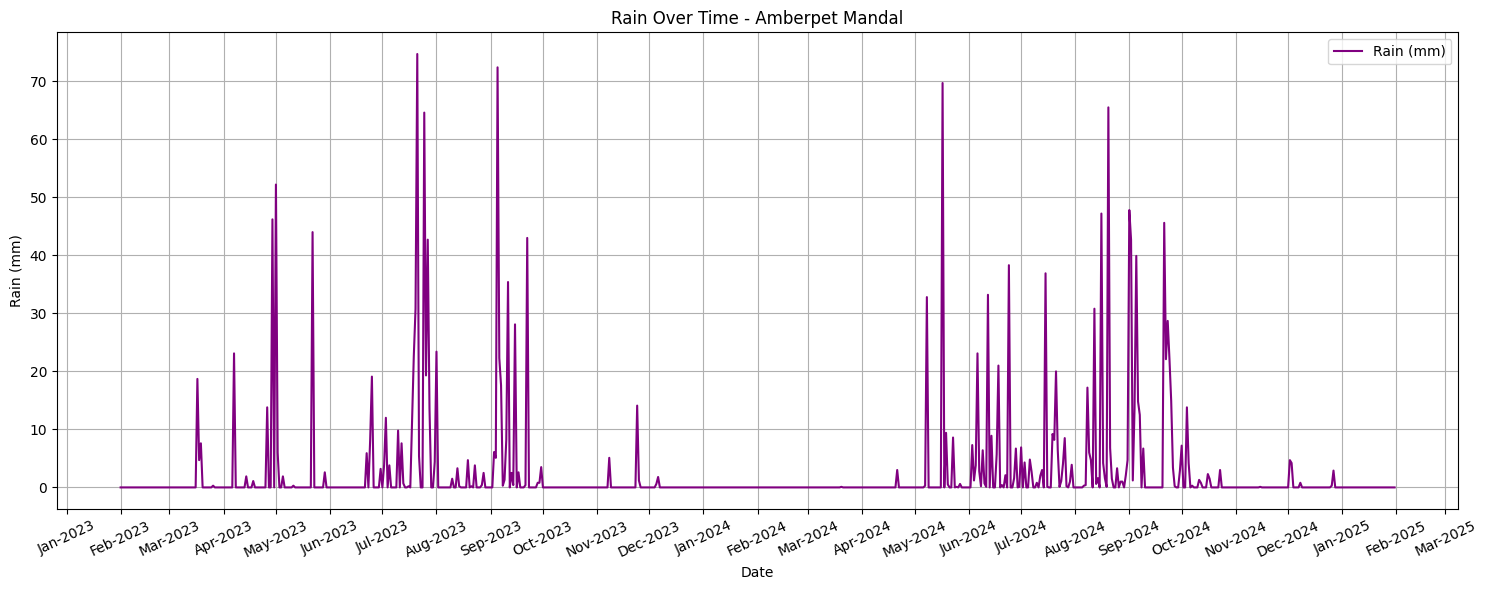

In [19]:
# plot rain over time on a line plot
plt.figure(figsize=(15, 6))
plt.plot(Amberpet_weather_cleaned.index, Amberpet_weather_cleaned['Rain (mm)'], label='Rain (mm)', color='purple')
plt.title('Rain Over Time - Amberpet Mandal')
plt.xlabel('Date')
plt.ylabel('Rain (mm)')
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

**Daily Rainfall Trends - Amberpet Mandal (Jan 2023– Feb 2025)**

Seasonal Rainfall Patterns:
- Monsoon Peaks - significant spikes in rainfall occur during the monsoon months (June to September) in both 2023 and 2024.These peaks are consistent with the monsoon season in Telangana, which typically brings heavy rainfall.
- Dry Periods - minimal or no rainfall is observed during the dry months (October to May), reflecting the semi-arid climate of the region.
Rainfall Intensity:
- Heavy Rainfall Events - some days experience rainfall exceeding 70 mm, indicating intense rainstorms during the monsoon.
- Low Rainfall Days - most days have little to no rainfall, as shown by the flat sections of the graph.
Yearly Trends:
- The rainfall pattern is consistent across 2023 and 2024, with similar monsoon peaks and dry periods.
- This highlights the predictable nature of rainfall in Amberpet Mandal, driven by the region's climate.

#### Min and Max Temperature over Time

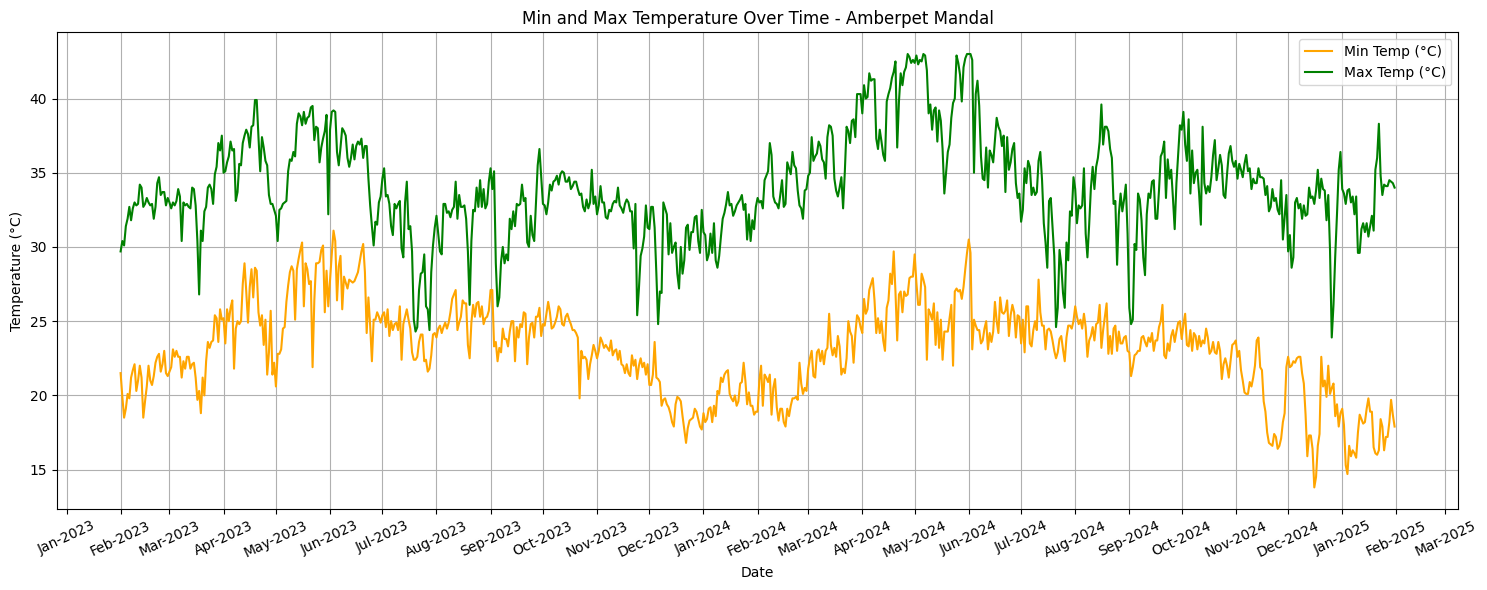

In [27]:
# plot Min and Max Temperature over time on a line plot
plt.figure(figsize=(15, 6))
plt.plot(Amberpet_weather_cleaned.index, Amberpet_weather_cleaned['Min Temp (°C)'], label='Min Temp (°C)', color='orange')
plt.plot(Amberpet_weather_cleaned.index, Amberpet_weather_cleaned['Max Temp (°C)'], label='Max Temp (°C)', color='green')
plt.title('Min and Max Temperature Over Time - Amberpet Mandal')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

**Temperature Trends – Amberpet Mandal (Jan 2023– Feb 2025)**
- The chart illustrates the daily minimum and maximum temperature trends in Amberpet Mandal from January 2023 to Feb 2025.
- The data shows **clear seasonal patterns,** with temperatures peaking between April and June each year (maximums often above 40°C) and reaching their lowest between December and January (minimums around 15–18°C). 
- The **gap between daily highs and lows widens during summer months**, indicating hot days and warm nights, while **winter months show smaller differences**, reflecting cooler days and cold nights. 
- Overall, the **temperature pattern remains consistent over the two-year period,** highlighting the region’s tropical climate characterized by hot summers, mild monsoons, and cool winters.

#### Min and Max Humidity over time

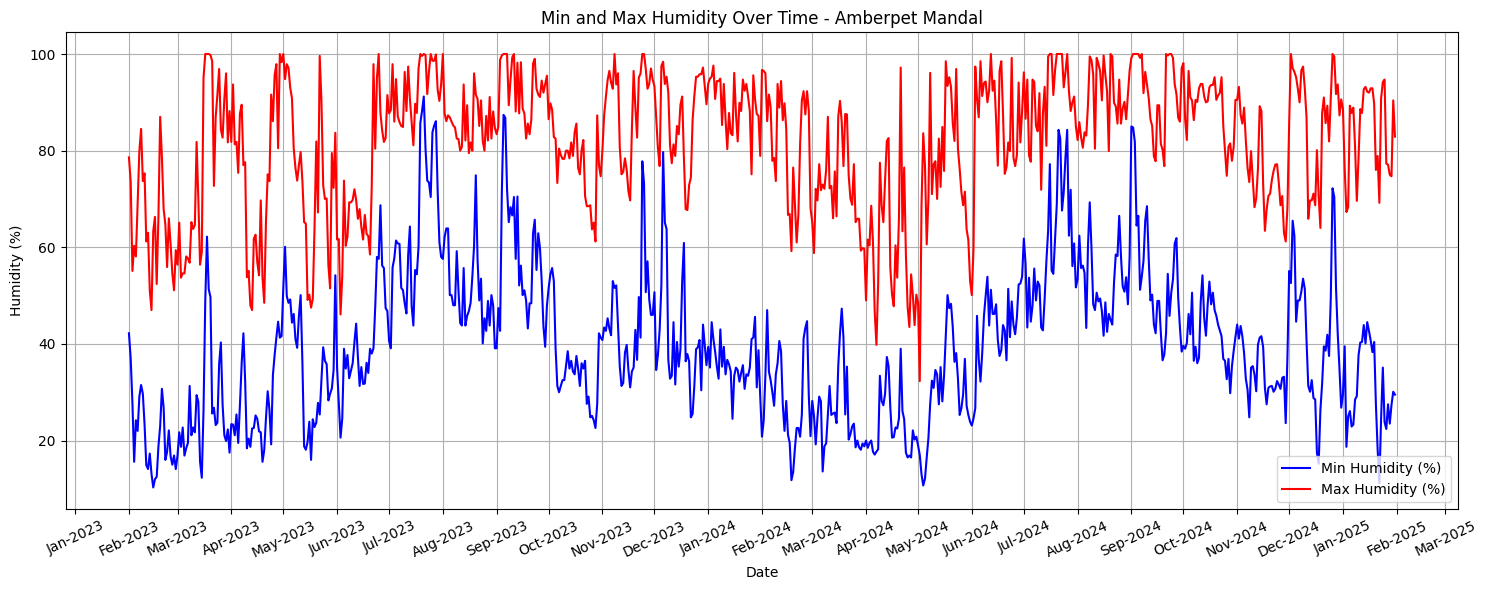

In [28]:
# plot Min and Max Humidity over time on a line plot
plt.figure(figsize=(15, 6))
plt.plot(Amberpet_weather_cleaned.index, Amberpet_weather_cleaned['Min Humidity (%)'], label='Min Humidity (%)', color='blue')
plt.plot(Amberpet_weather_cleaned.index, Amberpet_weather_cleaned['Max Humidity (%)'], label='Max Humidity (%)', color='red')
plt.title('Min and Max Humidity Over Time - Amberpet Mandal')
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

**Humidity Trends - Amberpet Mandal (Jan 2023– Feb 2025)**
- The analysis of minimum and maximum humidity levels from January 2023 to February 2025 shows a clear seasonal humidity cycle typical of a monsoon-influenced climate. 
- Maximum humidity consistently remains high (70–100%) throughout the year, peaking during the monsoon months (June–October), when the air is nearly saturated with moisture. 
- Minimum humidity values display strong variation, dropping as low as 10–20% during the pre-monsoon dry season (March–May), reflecting hot and arid daytime conditions.
- The large gap between minimum and maximum humidity outside the monsoon period indicates significant diurnal variation, driven by daytime heating and nighttime cooling. Conversely, this gap narrows during the monsoon, showing persistently moist air
- Overall, these trends highlight a predictable humidity pattern - **strong annual humidity cycle**

#### Min and Max Wind Speed over time

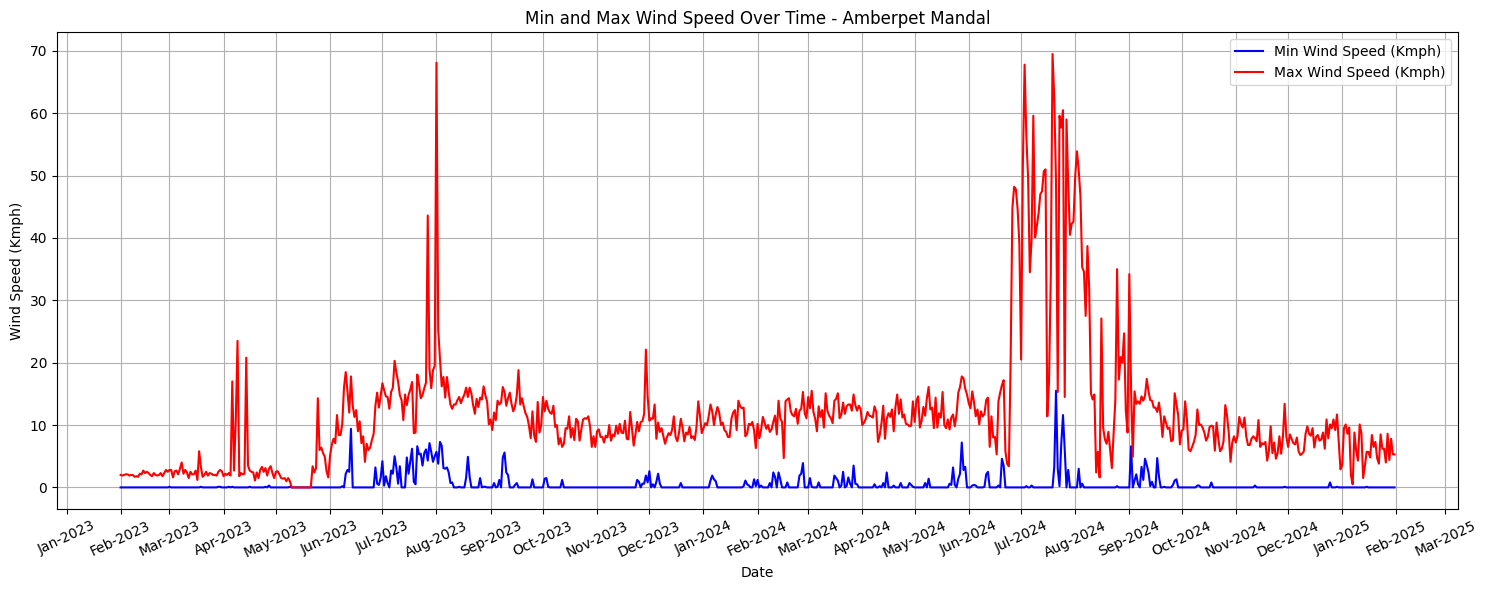

In [29]:
# plot Min and Max Wind Speed Over Time on a line plot
plt.figure(figsize=(15, 6))
plt.plot(Amberpet_weather_cleaned.index, Amberpet_weather_cleaned['Min Wind Speed (Kmph)'], label='Min Wind Speed (Kmph)', color='blue')
plt.plot(Amberpet_weather_cleaned.index, Amberpet_weather_cleaned['Max Wind Speed (Kmph)'], label='Max Wind Speed (Kmph)', color='red')
plt.title('Min and Max Wind Speed Over Time - Amberpet Mandal')
plt.xlabel('Date')
plt.ylabel('Wind Speed (Kmph)')
plt.legend()
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

**Wind Speed Trends - Amberpet Mandal (Jan 2023– Feb 2025)**
Seasonal Variation
- Recurring seasonal pattern in wind speeds, with peaks occuring mainly during mid-year months (June–August) — consistent with monsoon or pre-monsoon activity.
- Lower speeds dominate in winter months (Dec–Feb), indicating calmer atmospheric conditions.

Wind Speed Peaks
- Notable spikes occur around:
  - April–August 2023: Max wind speeds reach nearly 70 km/h.
  - June–August 2024: Another intense period, again reaching around 65–70 km/h.
- These spikes correspond to strong monsoon winds

Min Wind Speed Trends
- The minimum wind speeds stay close to 0–5 km/h most of the time.
- Slight rises in min speeds during May–August months show that even base wind activity increases during monsoon periods.
  
Post-Peak Calm
- After September 2024, both min and max speeds drop and stabilize, showing the end of windy or stormy conditions.

### 1.6.8 ETS decomposition

In [20]:
# check if data frame is time series
print(f"Is the index a DateTimeIndex? {isinstance(Amberpet_weather_cleaned.index, pd.DatetimeIndex)}")
print(f"Index frequency: {Amberpet_weather_cleaned.index.inferred_freq}")

Is the index a DateTimeIndex? True
Index frequency: D


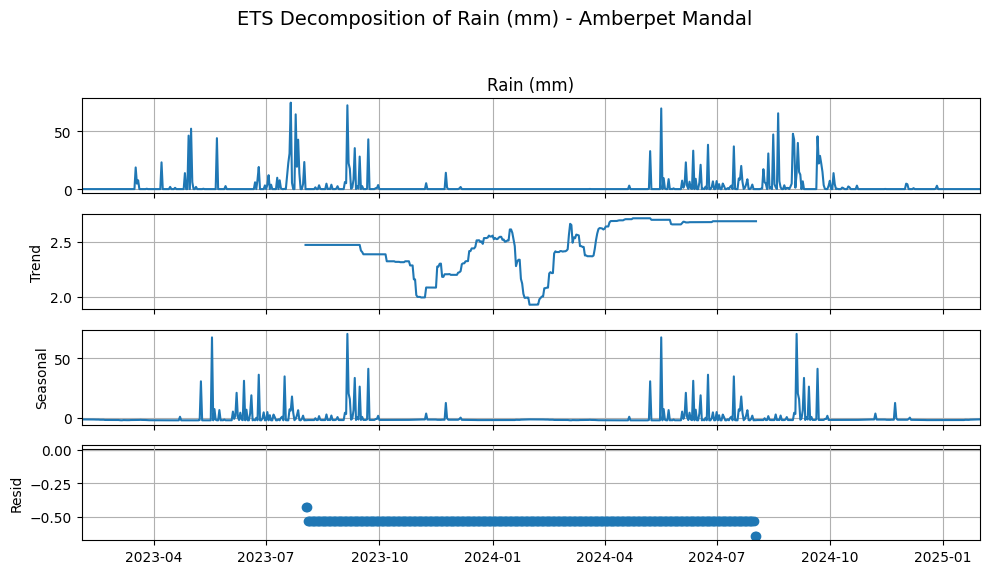

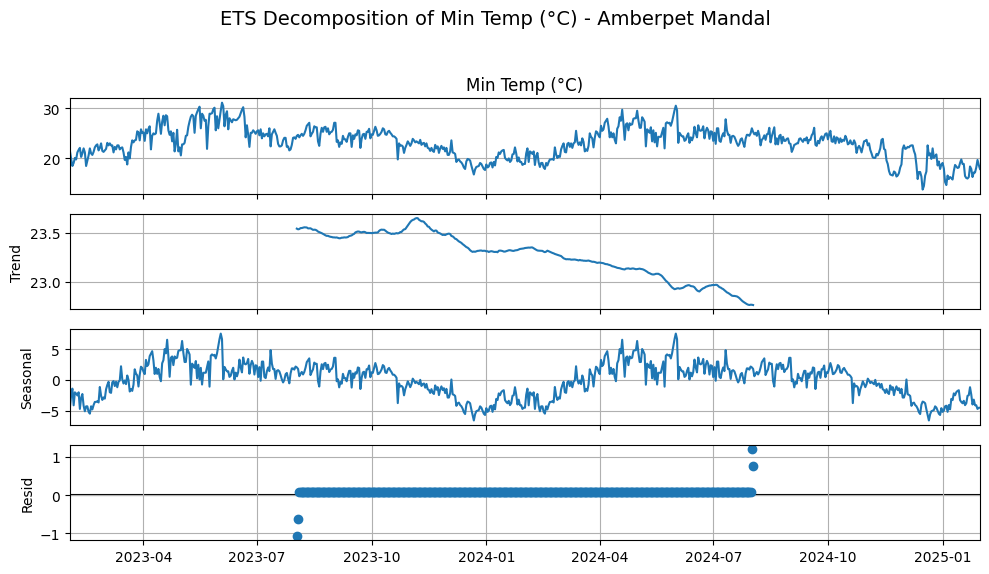

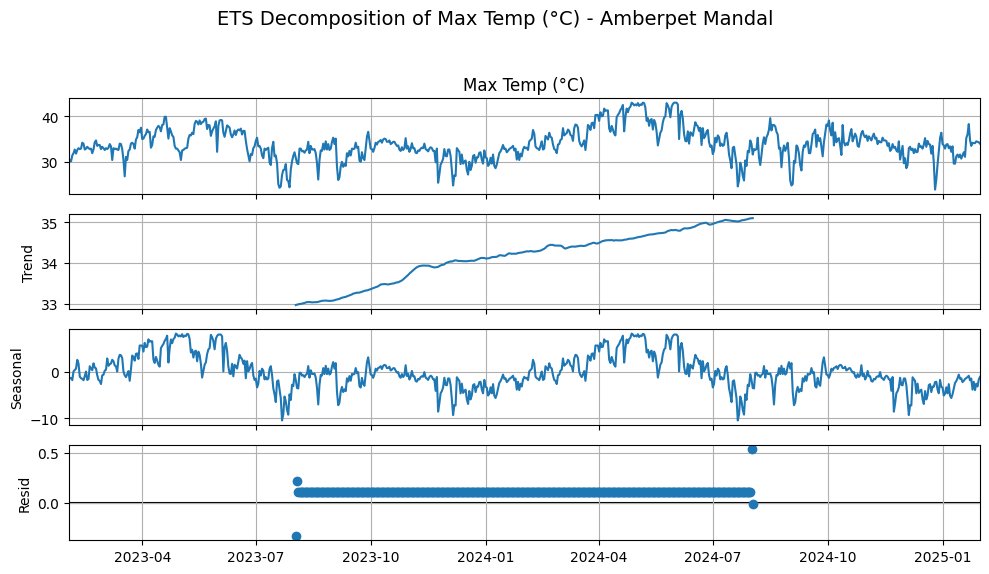

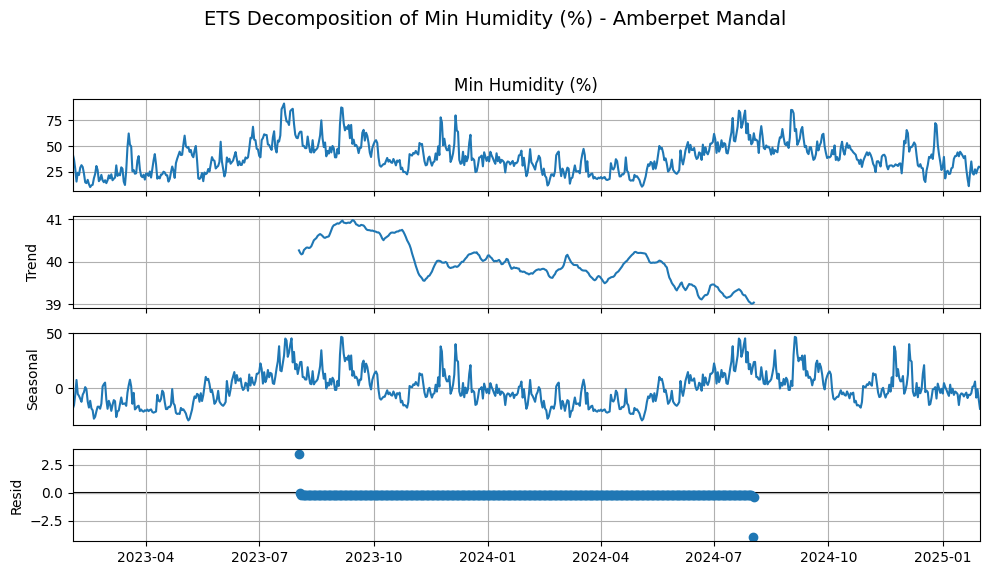

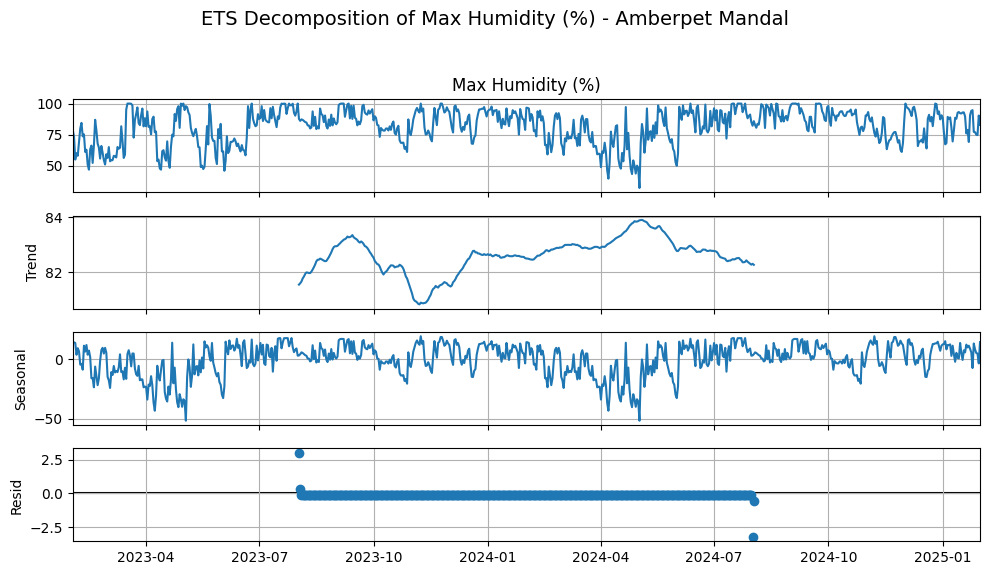

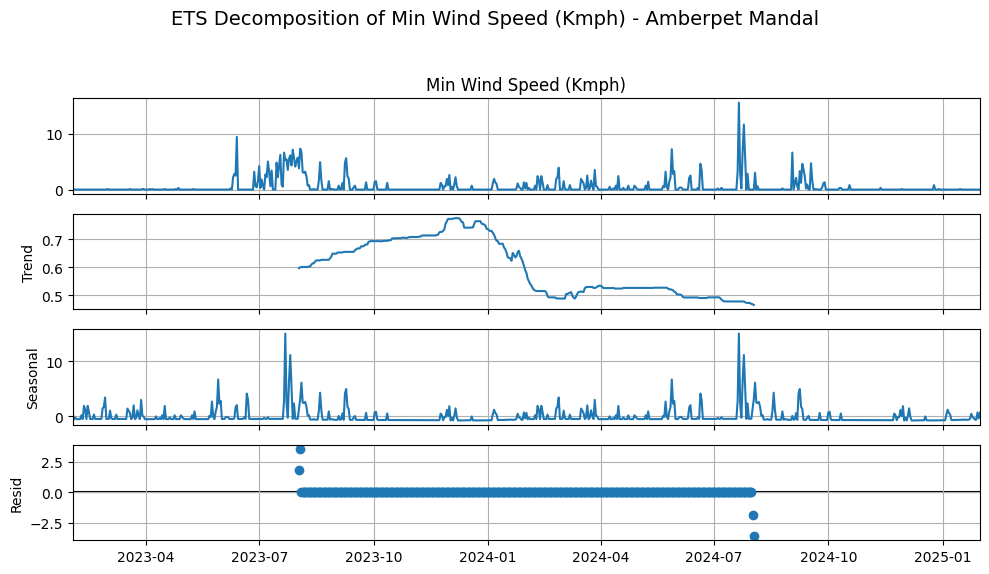

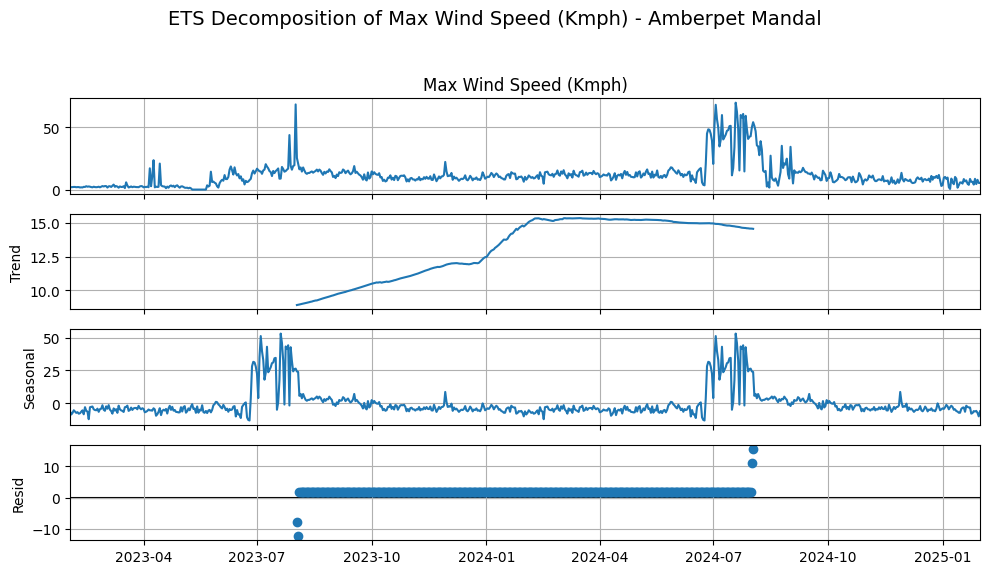

In [21]:
# Perform ETS decomposition for each variable and plot the results
# Using additive model as weather data typically has additive seasonality
decomposition_results = {}

for col in Amberpet_weather_cleaned.columns:
    try:
        series = Amberpet_weather_cleaned[col].dropna()
        result = seasonal_decompose(series, model='additive', period=365)
        decomposition_results[col] = result

        # Plot decomposition
        fig = result.plot()
        fig.set_size_inches(10, 6)
        fig.suptitle(f'ETS Decomposition of {col} - Amberpet Mandal', fontsize=14)
        for ax in fig.axes:
            ax.grid(True)
            ax.tick_params(labelsize=10)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    except Exception as e:
        print(f"Skipping {col} due to error: {e}")


**Rain ETS decomposition Plot**
- **Trend:** shows a slight dip in rainfall levels during late 2023 and early 2024, followed by stabilization. This reflects changes in overall rainfall patterns over the two-year period, which could be a temporary shift. 
- **Seasonal**: strong seasonal component present, hence the rain forecasting model should account for the monsoon seasonality. The seasonal component highlights the predictable nature of rainfall cycles.
- **Residual**: small & scattered, indicating most of the variability in rainfall is explained by the trend and seasonal components. 

**ETS Decomposition for Min Temp (°C)**
- **Trend**: shows a gradual decline in minimum temperatures from mid-2023 to early 2025. This could be due to changes in weather patterns or other environmental factors. The declining trend in minimum temperatures can help predict long-term changes in the region's climate.
- **Seasonal**: repeating seasonal patterns in minimum temperature. Peaks and troughs are visible, reflecting higher minimum temperatures during summer months and lower minimum temperatures during winter months. Also highlights the predictable nature of temperature cycles. The strong seasonal component indicates that forecasting models should account for temperature seasonality such as SARIMA
- **Residual**:relatively small, indicating that most of the variability in minimum temperature is explained by the trend and seasonal components.

**ETS Decomposition for Max Temp (°C)**
- Trend - shows a gradual increase in maximum temperatures from mid-2023 to early 2025. This could indicate warming trends or seasonal shifts in the region's climate
- Seasonal - repeating seasonal patterns in maximum temperature. Peaks and troughs are visible, reflecting higher maximum temperatures during summer months and lower maximum temperatures during winter months. The seasonal component highlights the predictable nature of temperature cycles. Forecasting models should account for temperature seasonality.
- Residual - relatively small, indicating that most of the variability in maximum temperature is explained by the trend and seasonal components.

**ETS Decomposition for Min Humidity (%)**
- Trend - initial increase in minimum humidity in mid-2023, followed by a gradual decline from late 2023 to early 2025. This could indicate changes in weather patterns or environmental factors affecting humidity levels. Declining trend in minimum humidity can help predict long-term changes in the region's climate
- Seasonal - repeating seasonal patterns in minimum humidity. Peaks and troughs are visible, reflecting higher minimum humidity during monsoon months and lower minimum humidity during dry months. The seasonal component highlights the predictable nature of humidity cycles. Forecasting models should account for humidity seasonality.
- Residual - relatively small, indicating that most of the variability in minimum humidity is explained by the trend and seasonal components.

**ETS Decomposition for Max Humidity (%)**
- Trend - shows an initial decrease in maximum humidity in mid-2023, followed by a gradual incline from late 2023 to early 2025. This could indicate changes in weather patterns or environmental factors affecting humidity levels. This can help predict long-term changes in the region's climate.
- Seasonal - repeating seasonal patterns in maximum humidity. Peaks and troughs are visible, reflecting higher maximum humidity during monsoon months (June–September) and lower maximum humidity during dry months (October–May). The seasonal component highlights the predictable nature of humidity cycles. Forecasting models should account for humidity seasonality.
- Residual - relatively small, indicating that most of the variability in maximum humidity is explained by the trend and seasonal components

**ETS Decomposition for Min Wind Speed (Kmph)**
- Trend - shows an initial increase in minimum wind speed during mid-2023, followed by a gradual decline from late 2023 to early 2025. This could indicate changes in atmospheric conditions or weather patterns affecting wind activity. Declining trend in minimum wind speeds can help predict long-term changes in the region's wind activity.
- Seasonal - repeating seasonal patterns in minimum wind speed. Peaks and troughs are visible, reflecting higher minimum wind speeds during certain months (likely monsoon or pre-monsoon periods) and lower speeds during calmer months (e.g., winter). The seasonal component highlights the predictable nature of wind speed cycles. Forecasting models should account for wind speed seasonality.
- Residual: relatively small, indicating that most of the variability in minimum wind speed is explained by the trend and seasonal components

**ETS Decomposition for Max Wind Speed (Kmph)**
- Trend - rises steadily from early 2023, peaks around mid-2024, and then slightly declines. This suggests a period of increasing wind activity, possibly linked to seasonal weather patterns. 
- Seasonal - repeating seasonal patterns. There are pronounced peaks during the same periods as the observed spikes, confirming strong seasonality—likely corresponding to the monsoon or storm seasons. Max wind speed is highly seasonal, with regular peaks during monsoon months.
- Residual - most residuals are close to zero, but there are occasional outliers, indicating some extreme wind events not explained by regular patterns. Most variability is explained by trend and seasonality, but some extreme events remain.

•	Models should account for both strong seasonality and trend.

**Overall insight**
- **Use multivariate time series analysis models.**
- **Include seasonality of the 7 weather conditions into the forecast model**

### 1.6.9 ACF/PACF plots

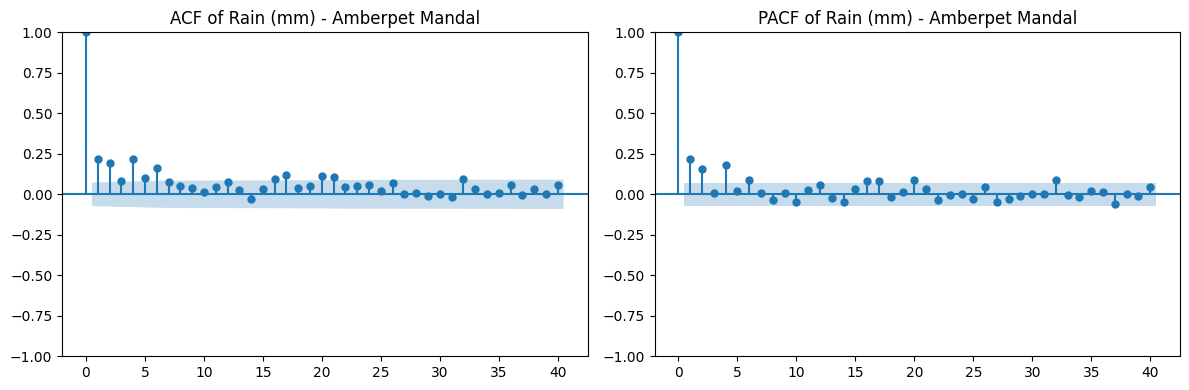

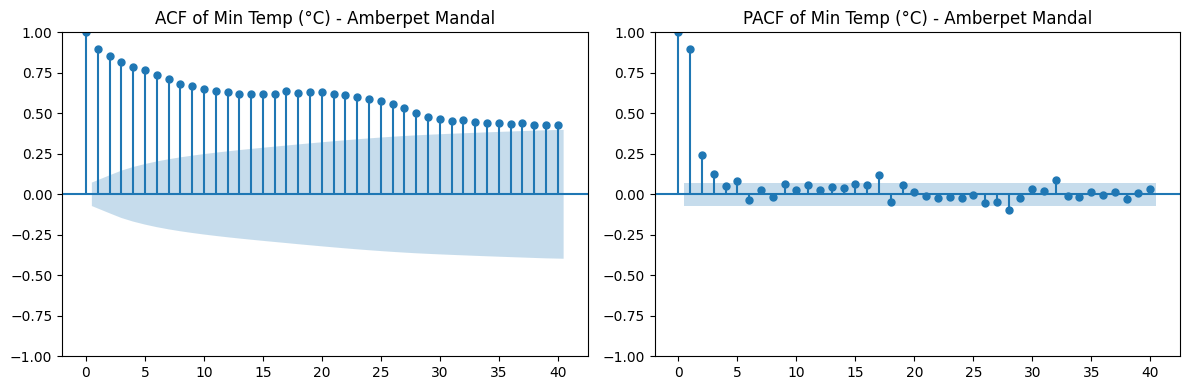

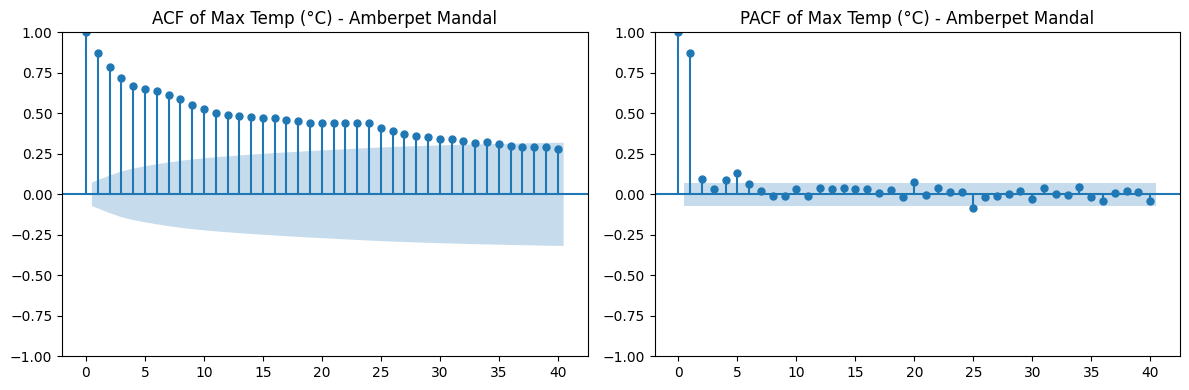

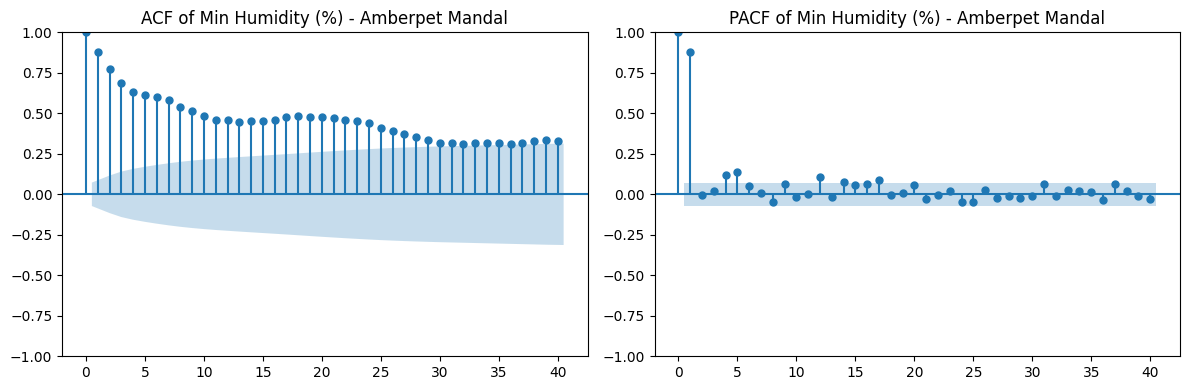

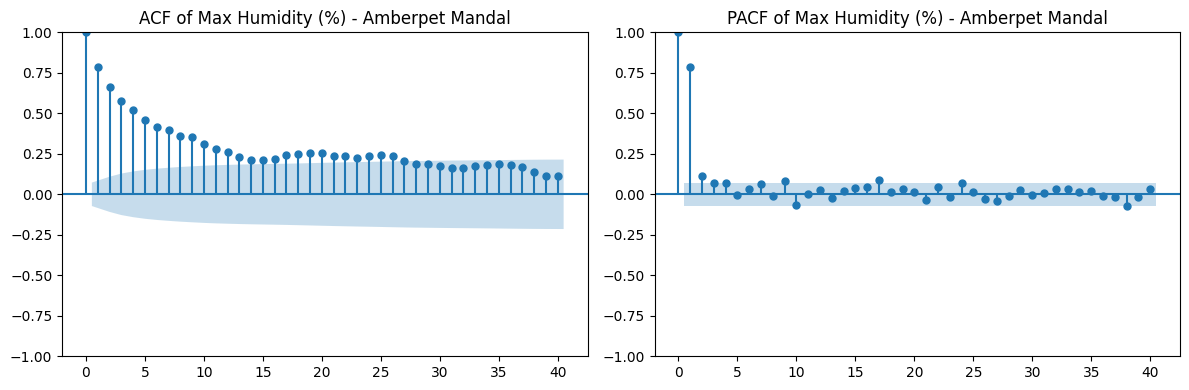

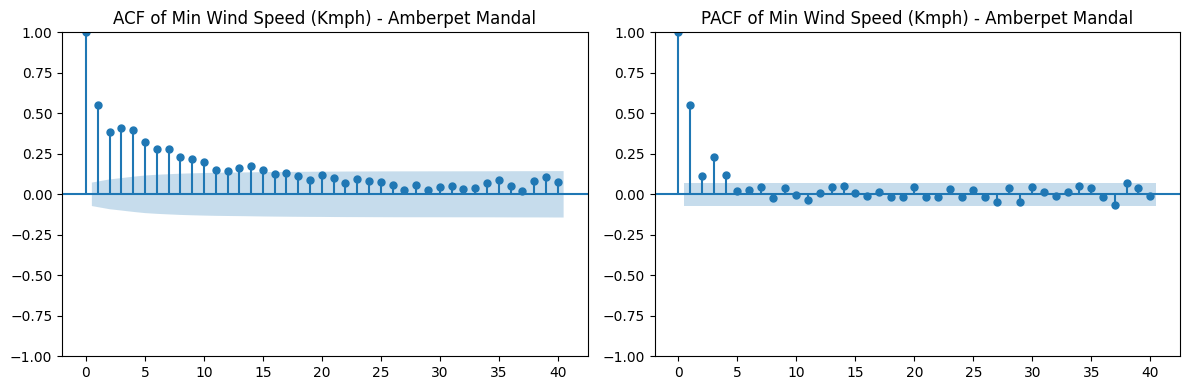

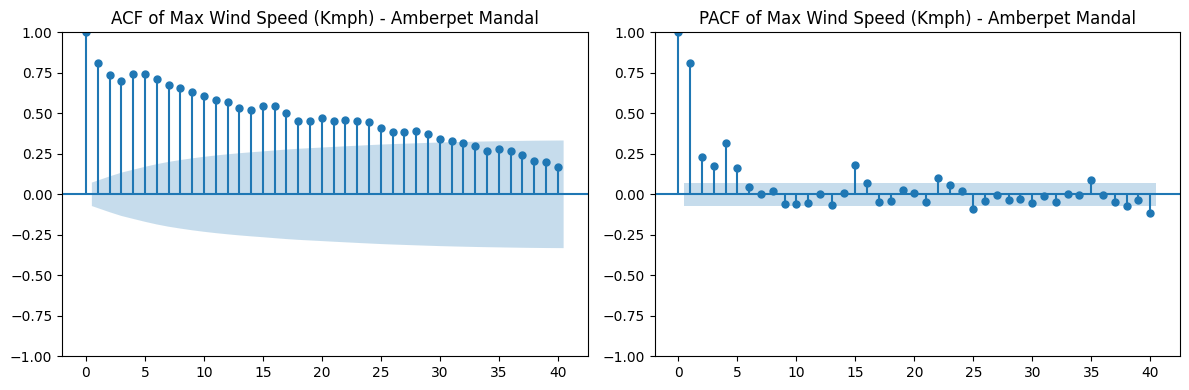

In [22]:
# Plot ACF and PACF for each variable
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
for col in Amberpet_weather_cleaned.columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(Amberpet_weather_cleaned[col].dropna(), ax=axes[0], lags=40)
    plot_pacf(Amberpet_weather_cleaned[col].dropna(), ax=axes[1], lags=40)
    axes[0].set_title(f'ACF of {col} - Amberpet Mandal')
    axes[1].set_title(f'PACF of {col} - Amberpet Mandal')
    plt.tight_layout()
    plt.show()


**Rain**
- ACF plot & PACF plot - Rainfall is likely non-persistent —**past values don’t strongly predict future values.** Beyond lag 0, most values are close to zero, suggesting weak autocorrelation.
  
**Min Temp (°C)**
- ACF Plot
  - shows strong autocorrelation at multiple lags, especially in the early lags (e.g., lag 1–10), with several bars extending beyond the confidence bounds. This indicates persistent temporal dependence — today's minimum temperature is strongly related to previous days.
  - Temp likely exhibits seasonality or smooth trends, making it suitable for autoregressive modeling. 
  - The slow decay in autocorrelation suggests a non-stationary process, possibly requiring differencing or seasonal adjustment.
- PACF Plot
  - Significant spikes at early lags (especially lag 1, possibly lag 2 or 3) followed by a sharp drop.
  - This pattern is typical of an AR(p) process, where p is the number of significant lags. 
  - You can likely model this series with an **AR(1) or AR(2) terms.**
  - This pinpoint the number of AR terms to include in VARMAX models.

**Max Temp (°C)**
- ACF Plot
  - ACF shows strong positive autocorrelation across many lags, with several bars well above the confidence bounds.
  - This suggests a persistent and smooth temporal structure, likely driven by seasonal or diurnal cycles. 
  - Max temperature is highly predictable from its past values, making it ideal for autoregressive modeling.
  - The slow decay in autocorrelation implies non-stationarity, possibly due to trend or seasonality.
- PACF Plot
  - Significant spikes at lag 1, and possibly lag 2 or 3, followed by a sharp drop.
  - This pattern is characteristic of an AR(p) process, where p is small (likely 1–3).
  - You can model this series effectively **with AR(1) or AR(2) terms.**
  
**Min Humidity (%)**
- ACF Plot
  - Most autocorrelation values fall within the confidence bounds, except possibly lag 1. This indicates weak autocorrelation, past values of minimum humidity don’t strongly predict future values.
  - The series may behave more like white noise or be influenced by external factors rather than its own history. Autoregressive components (AR terms) not useful for this variable in isolation.
- PACF Plot
  - Similar to ACF, most partial autocorrelations are insignificant, with no dominant spikes beyond lag 0. This suggests no strong direct lag relationships, reinforcing the idea that the series lacks internal structure.
  - PACF confirms that AR terms are likely unnecessary. **If modeling use it as an exogenous variable in a multivariate framework.**

**Max Humidity (%)**
- ACF Plot
  - Several lags show statistically significant positive autocorrelation, especially in the early lags (e.g., lag 1–10). This suggests that Max Humidity has temporal persistence — past values influence future values.
- PACF Plot
  - A few early lags (e.g., lag 1, possibly lag 2 or 3) show significant partial autocorrelation. After these initial lags, the PACF drops off sharply, indicating a low-order AR structure.
  - Suggests an **AR(1) or AR(2) process could capture most of the direct lagged influence.**

**Min Wind Speed (Kmph)**
- ACF Plot
  - Strong autocorrelation at lag 1, tapering off gradually across higher lags.
  - This pattern suggests the series has persistent memory — past values influence future ones over multiple time steps.
  - The slow decay is characteristic of an AR process, possibly with some MA components.
  - Lags beyond ~10 still show mild significance, hinting at long-range dependence or seasonality.

- PACF Plot
  - Sharp cutoff after lag 1 — the bar at lag 1 is significant, while subsequent lags drop within the confidence bounds.
  - This is a classic signature of an AR(1) process: the current value depends primarily on the immediately preceding value.
  - The lack of significant partial autocorrelation beyond lag 1 suggests that higher-order AR terms may not add much explanatory power.

For multivariate modeling (e.g., VAR), this supports using 1–2 lags for wind speed.

**Max Wind Speed (Kmph)**
- ACF Plot
  - Significant autocorrelation across many lags, with several bars exceeding the confidence bounds.
  - This suggests strong persistence and possibly seasonal or cyclical behavior.
  - The slow decay pattern is typical of an autoregressive process, possibly with moving average components.
  - If the decay is exponential, it may indicate an ARMA structure; if it’s more gradual, long-memory or seasonal effects could be present.
- PACF Plot
  - Only a few lags (especially lag 1 and possibly lag 2 or 3) show significant partial autocorrelation.
  - This implies that most of the predictive power is concentrated in the first few lags.
  - The sharp drop after lag 1 or 2 is consistent with an AR(1) or AR(2) process.
  - The lack of significant PACF beyond lag 3 suggests that higher-order AR terms may not be necessary.